In [2]:
import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "FutureWarning")
plt.style.use("dark_background")

# дополнительные импорты для задачи Луны

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy
from sklearn.datasets import make_moons #берем датасет Луна
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm.autonotebook import tqdm #нужен для просмотра времени обучения нейросети

In [3]:
!pip install torchmetrics==0.9.3

In [22]:
# https://stackoverflow.com/questions/39719308/keras-model-creates-linear-classification-for-make-moons-data
def plot_decision_boundary(model: nn.Module) -> None:
    # установим минимальные и максимальные значения и добавим паддинг (отступы)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.1
    # сгенерируем сетку точек, с расстоянием h между ними
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # предскажем
    model.eval() # переводим модель в режим инференса
    with torch.no_grad(): # градиент не считаем
      data = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32)
      probs = torch.sigmoid(model(data).reshape(xx.shape))
      probs = probs.numpy().reshape(xx.shape)

    # отрисуем точки
    plt.figure(figsize=(15, 6))
    plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    plt.scatter(X[100:, 0], X[100:, 1], 
                c=y[100:], 
                cmap="RdBu", 
                s=50, 
                linewidth=1,
                alpha=.42, 
                ec="black")
    plt.title("Decision Boundary")
    plt.axis("off")
    plt.show()

# pyTorch vs Numpy

### Конвертация из numpy в torsh и обратно

#### Пример 1 - Вектор

In [12]:
#Создадим простой вектор
vec = np.array([9,8,7])

In [13]:
vec

array([9, 8, 7])

In [14]:
vec.shape

(3,)

In [15]:
#Переведем вектор в torch
vec_tensor = torch.from_numpy(vec)

In [16]:
vec_tensor

tensor([9, 8, 7], dtype=torch.int32)

In [17]:
vec_tensor.shape

torch.Size([3])

In [18]:
vec_tensor.size()

torch.Size([3])

In [19]:
#Занулим тензор-вектор
vec_tensor -= vec_tensor
vec_tensor

tensor([0, 0, 0], dtype=torch.int32)

In [22]:
#вызовем исходный вектор из numpy
#он так же зануляется, важно это помнить
vec

array([0, 0, 0])

- ВАЖНО! Изменяя тензор, ты меняешь и исходник!

#### Пример 2 - Матрица

In [26]:
#создадим матрицу
matrix = np.array([[1,3,9],[5,7,3]])
matrix

array([[1, 3, 9],
       [5, 7, 3]])

In [28]:
matrix.shape

(2, 3)

In [31]:
#переведем ее в тензор, аналогично вектору
matrix_tensor = torch.from_numpy(matrix)
matrix_tensor

tensor([[1, 3, 9],
        [5, 7, 3]], dtype=torch.int32)

In [36]:
#создадим картинку
pic = torch.rand(3,224,224)
pic

tensor([[[0.1269, 0.6172, 0.6103,  ..., 0.9800, 0.3115, 0.4825],
         [0.6276, 0.4509, 0.9325,  ..., 0.7692, 0.9073, 0.7928],
         [0.9187, 0.0165, 0.3081,  ..., 0.2476, 0.7615, 0.6460],
         ...,
         [0.8247, 0.6875, 0.4594,  ..., 0.7486, 0.2351, 0.1341],
         [0.9465, 0.5525, 0.9754,  ..., 0.6821, 0.4893, 0.4236],
         [0.5098, 0.4143, 0.9372,  ..., 0.2492, 0.6413, 0.0831]],

        [[0.9883, 0.4773, 0.9992,  ..., 0.7255, 0.7487, 0.0913],
         [0.4857, 0.6997, 0.8745,  ..., 0.3947, 0.9065, 0.4082],
         [0.9040, 0.1325, 0.6632,  ..., 0.6700, 0.4610, 0.6634],
         ...,
         [0.5849, 0.3343, 0.3035,  ..., 0.5584, 0.7917, 0.9600],
         [0.8998, 0.6757, 0.9579,  ..., 0.0501, 0.7202, 0.0459],
         [0.0904, 0.9628, 0.4014,  ..., 0.8227, 0.1690, 0.3795]],

        [[0.3658, 0.9552, 0.4298,  ..., 0.9076, 0.3004, 0.6513],
         [0.9727, 0.5042, 0.1429,  ..., 0.3597, 0.6709, 0.2365],
         [0.2996, 0.2788, 0.3454,  ..., 0.1269, 0.7238, 0.

In [37]:
pic.shape

torch.Size([3, 224, 224])

In [38]:
#переведем матрицу обратно в numpy

In [39]:
matrix_tensor.numpy()

array([[1, 3, 9],
       [5, 7, 3]])

### Создание случайных Тензоров

In [40]:
torch.tensor(np.array([0,1.,2,3]))

tensor([0., 1., 2., 3.], dtype=torch.float64)

Сейчас мы рассмотрим основные способы создание тензоров. У torch все строже, чем у numpy, поэтому необходимо указывать типы данных при создании. Именно это мы сейчас и рассмотрим.

In [45]:
#создаем тензоры 32, 16 и 64 бита
print(
    torch.FloatTensor().dtype,\
    torch.HalfTensor().dtype,\
    torch.DoubleTensor().dtype, sep = '\n'
)

torch.float32
torch.float16
torch.float64


In [47]:
#рассмотрим целочисленные тензоры
print(
    torch.IntTensor().dtype,\
    torch.ShortTensor().dtype,\
    torch.LongTensor().dtype, sep = '\n'
)

torch.int32
torch.int16
torch.int64


- Научимся конвертировать типы

Это необходимо нам, чтобы менять данные, если они подаются не в том виде

In [49]:
#наша матрица
matrix_tensor.dtype

torch.int32

- первый способ - .type_as()

In [52]:
matrix_tensor = matrix_tensor.type_as(torch.FloatTensor())
matrix_tensor.dtype

torch.float32

- второй способ - .to()

In [58]:
#создадим новый тензор для наглядности
tensor_ = torch.tensor(np.array([0,1.,2,3]))

In [59]:
#Посмотрим его тип
tensor_.dtype

torch.float64

In [56]:
#Преобразуем
tensor_.to(torch.FloatTensor())

tensor([0., 1., 2., 3.])

In [60]:
#Проверим
tensor_.dtype

torch.float64

In [63]:
#Создаем рандомный тензор
torch.FloatTensor(42)

tensor([6.4805e-10, 6.3010e-10, 6.6376e-07, 6.8357e-04, 2.7098e-09, 1.0859e-05,
        6.4097e-10, 1.4580e-19, 1.1495e+24, 3.0956e-18, 3.7748e-08, 1.7585e-04,
        1.3443e+22, 1.7156e-07, 4.2531e-05, 2.7180e+23, 1.7079e-07, 2.1363e-07,
        3.0681e-18, 2.0552e+32, 1.8755e+28, 3.1093e-18, 2.0552e+32, 1.8755e+28,
        3.1093e-18, 1.2845e+31, 1.8395e+25, 6.1963e-04, 2.0768e+20, 2.6845e+23,
        2.1955e-04, 2.0778e+20, 3.3586e-06, 2.0892e+20, 1.0514e-05, 4.1300e-08,
        2.3076e-12, 1.8788e+31, 7.9303e+34, 6.1949e-04, 1.8590e+34, 7.7767e+31])

In [66]:
torch.FloatTensor(42).shape

torch.Size([42])

In [67]:
torch.ones(2,1)

tensor([[1.],
        [1.]])

In [68]:
torch.zeros(2,1)

tensor([[0.],
        [0.]])

### Инициализация из заданных распределений

In [70]:
x = torch.randn((4,2,4))
x

tensor([[[ 1.3643, -0.5046, -0.6052,  1.7805],
         [-0.0981, -0.5422, -0.1481,  0.8549]],

        [[ 0.0997, -0.5488,  1.1891, -0.8772],
         [-0.3948, -0.5683,  0.5613,  1.7160]],

        [[-2.1647, -1.0980, -0.4289, -0.2725],
         [ 0.9276, -1.1354, -0.6033,  0.9179]],

        [[-0.2740, -0.0926,  1.5912,  1.3064],
         [-0.0807, -0.2115, -0.0717,  0.0378]]])

In [71]:
x.size()

torch.Size([4, 2, 4])

In [72]:
#приведем наш тензор к равномерному распределению
x.uniform_(0,2)

tensor([[[1.5096, 0.3955, 0.0030, 1.9485],
         [0.6860, 0.4908, 0.9205, 1.4795]],

        [[1.8188, 1.2462, 1.7960, 0.0853],
         [0.3148, 0.0214, 0.9815, 1.2002]],

        [[1.5308, 0.9992, 0.6958, 0.1651],
         [0.2682, 1.5167, 0.1053, 1.6110]],

        [[0.1255, 0.4281, 0.2509, 1.5940],
         [1.2263, 1.0968, 0.2995, 0.2518]]])

- ВАЖНО! функция - .uniform_() имеет нижнее подчеркивание _. Такие функции производят изменения inplace

In [73]:
#ПРиведем к распределению бернулли
x.bernoulli_(p=0.5)

tensor([[[1., 1., 1., 1.],
         [0., 1., 1., 0.]],

        [[0., 1., 0., 1.],
         [0., 1., 1., 1.]],

        [[1., 1., 0., 0.],
         [0., 1., 0., 1.]],

        [[1., 0., 0., 1.],
         [0., 1., 0., 0.]]])

In [74]:
x.normal_(mean=0, std=1)

tensor([[[ 0.7006,  0.0585, -0.3159,  0.4419],
         [ 0.5647,  0.7964, -0.3778, -0.8843]],

        [[-0.2794, -0.1907,  0.4743, -2.4615],
         [ 0.7641, -0.7115, -0.2612,  1.1438]],

        [[-0.4735,  0.0412, -0.9434,  1.0634],
         [-0.6443, -0.6359, -0.1736,  1.0178]],

        [[-0.1418, -0.4358, -0.9070, -0.5860],
         [-1.7334, -0.9684, -1.7837,  0.1335]]])

### Основные операции над тензорами

In [75]:
#создадим два тензора

In [78]:
x = torch.FloatTensor([[1,1,1],[1,1,1]])
y = torch.FloatTensor([[-1,-1,-1],[-1,-1,-1]])
x, y

(tensor([[1., 1., 1.],
         [1., 1., 1.]]),
 tensor([[-1., -1., -1.],
         [-1., -1., -1.]]))

In [77]:
#сложение
x + y

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [84]:
x.add(y)

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [85]:
# если мы поставим _ , то изменим наш x
x.add_(y)

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [86]:
x

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [88]:
#инициализируем снова наш x
x = torch.FloatTensor([[1,1,1],[1,1,1]])

In [89]:
#вычитание
x - y

tensor([[2., 2., 2.],
        [2., 2., 2.]])

In [92]:
x.sub(y)

tensor([[2., 2., 2.],
        [2., 2., 2.]])

In [90]:
#умножение
x * y

tensor([[-1., -1., -1.],
        [-1., -1., -1.]])

In [93]:
x.mul(y)

tensor([[-1., -1., -1.],
        [-1., -1., -1.]])

In [91]:
#деление
x / y

tensor([[-1., -1., -1.],
        [-1., -1., -1.]])

In [94]:
x.div(y)

tensor([[-1., -1., -1.],
        [-1., -1., -1.]])

- ко всем, вышеперечисленным операциям можно добавить _ и провести их inplace

In [107]:
x = torch.FloatTensor([[1,1,1],[1,1,2]])
y = torch.FloatTensor([[-1,1,1],[2,-1,-1]])

In [108]:
#сравнение
x > y

tensor([[ True, False, False],
        [False,  True,  True]])

In [109]:
x != y

tensor([[ True, False, False],
        [ True,  True,  True]])

In [110]:
x == y

tensor([[False,  True,  True],
        [False, False, False]])

- в последствии сравнения можно использовать как маску

In [111]:
mask = x > y

In [112]:
#Получаем только те позиции. которые больше
x[mask]

tensor([1., 1., 2.])

In [113]:
y.abs()

tensor([[1., 1., 1.],
        [2., 1., 1.]])

In [2]:
#Посмотрим на скалярное произведение
x = torch.FloatTensor([[1,2,3]])
y = torch.FloatTensor([[-1,2,-3]])

In [116]:
x @ y.t()

tensor([[-6.]])

In [118]:
x.mm(y.t())

tensor([[-6.]])

- Выводы: большинство операций, которые есть в Numpy, можно найти и в torch

### Использование агрегаций

In [4]:
x = torch.FloatTensor([[1,2,3], [3,2,1]])
y = torch.FloatTensor([[-1,2,-3], [3,2,1]])

In [5]:
x

tensor([[1., 2., 3.],
        [3., 2., 1.]])

In [6]:
x.size()

torch.Size([2, 3])

In [9]:
#рассмотрим на примере суммы
#здесь все складывается последовательно
x.sum()

tensor(12.)

In [18]:
#получим количество столбцов и строк
axis = [ax for ax in x.size()]
axis, axis[0], axis[1]

([2, 3], 2, 3)

In [22]:
#суммируем по вертикали (столбцы)
x.sum(0), x.sum(0).size()

(tensor([4., 4., 4.]), torch.Size([3]))

In [21]:
#суммируем по горизонтали (строки)
x.sum(1), x.sum(1).size()

(tensor([6., 6.]), torch.Size([2]))

In [24]:
#примением .max
#просто получаем максимальное число из матрицы
x.max()

tensor(3.)

In [25]:
x.max().item()

3.0

In [28]:
#Сделаем по столбцам
x.max(0)

torch.return_types.max(
values=tensor([3., 2., 3.]),
indices=tensor([1, 0, 0]))

In [34]:
#индексы или значения можно использовать в будущем для различных масок флитрации
x.max(0).indices, x.max(0).values

(tensor([1, 0, 0]), tensor([3., 2., 3.]))

In [35]:
#Сделаем по строкам
x.max(1)

torch.return_types.max(
values=tensor([3., 3.]),
indices=tensor([2, 0]))

Список соответствий функций [torch vs numpy](#https://github.com/torch/torch7/wiki/Torch-for-Numpy-users)

### Работа с GPU (CUDA)

[Nvidia docs](https://docs.nvidia.com/cuda/) и [WikiPedia](https://en.wikipedia.org/wiki/CUDA)

In [10]:
#проверим доступность GPU
torch.cuda.is_available()

True

In [3]:
#проверяем наличие карты нвидеа
!nvidia-smi

Wed Apr 26 17:01:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070       WDDM | 00000000:07:00.0  On |                  N/A |
|  0%   50C    P8               11W / 151W|   2221MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
#создаем тензор, с которым будем работать
x = torch.FloatTensor(420, 1000000).normal_()
x

tensor([[ 0.9331,  2.2396,  1.6059,  ...,  1.3577,  0.6193, -1.0676],
        [ 0.4187,  0.3551, -0.9175,  ..., -1.3167, -0.7129, -0.3747],
        [ 1.3507,  1.7509, -1.0381,  ..., -0.1588,  0.7731, -0.3499],
        ...,
        [-0.5754, -1.0509,  1.1946,  ..., -0.4566,  0.7692, -0.5241],
        [-1.3437,  0.2827, -0.5152,  ...,  0.1341, -0.7697,  1.0393],
        [-0.0244,  0.1394,  0.7509,  ...,  1.0217, -0.1386, -0.4020]])

In [5]:
#проверим находится ли тензор на GPU
x.is_cuda

False

По умолчанию все свои тензоры торч устанавливает на CPU

In [8]:
#перенесем тензор на GPU
x = x.to('cuda')

In [9]:
#Проверим, что тензор на GPU
x.is_cuda

True

In [11]:
#вернем все на CPU
x = x.cpu()

In [13]:
#Проверим
x.is_cpu

True

In [14]:
!nvidia-smi

Wed Apr 26 17:18:43 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070       WDDM | 00000000:07:00.0  On |                  N/A |
|  0%   48C    P2               43W / 151W|   5871MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Мы можем наблюдать, что было использовано 3000Mb

Для очистки кэша необходимо выполнить команду, торч не всегда чистит кэш за собой.

Лучше выполнять ее после каждого обучения

In [30]:
#Очистим кэш
torch.cuda.empty_cache()

In [31]:
#првоеряем GPU
!nvidia-smi

Thu Apr 27 20:16:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070       WDDM | 00000000:07:00.0  On |                  N/A |
|  0%   49C    P8               12W / 151W|   2526MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Для того, чтобы удобнее было переводить на GPU, мы создадим глобальную переменную DEVICE.

Если у нас доступен GPU, то мы переведем тензор на него, если нет. то оставим все как есть

In [32]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
DEVICE

'cuda'

In [34]:
#создадим две матрицы
x = torch.FloatTensor(6000, 10000).normal_()
y = torch.FloatTensor(6000, 10000).normal_()

- замерим время, которое займет операция на CPU

In [35]:
%%time
x.mul(y)

CPU times: total: 266 ms
Wall time: 33 ms


tensor([[ 0.2825, -0.5787,  0.2069,  ..., -0.2414, -0.6286, -0.3167],
        [ 0.1202,  0.5741, -0.3469,  ..., -0.7218,  2.2993,  0.1182],
        [-0.0120, -0.0652, -1.9559,  ...,  0.1175,  0.2207,  0.3668],
        ...,
        [-0.8495,  0.1856,  0.6666,  ..., -0.1312,  0.1635, -1.7862],
        [-0.2793, -0.0367, -0.0086,  ...,  0.1000,  0.3264,  0.3050],
        [-0.7319,  0.1632,  0.3384,  ...,  1.5319, -0.3356,  0.4014]])

- сравним теперь с GPU

In [36]:
x = x.to(DEVICE)
y = y.to(DEVICE)

In [37]:
x.is_cuda, y.is_cuda

(True, True)

In [38]:
%%time
x.mul(y)

CPU times: total: 1.14 s
Wall time: 1.15 s


tensor([[ 0.2825, -0.5787,  0.2069,  ..., -0.2414, -0.6286, -0.3167],
        [ 0.1202,  0.5741, -0.3469,  ..., -0.7218,  2.2993,  0.1182],
        [-0.0120, -0.0652, -1.9559,  ...,  0.1175,  0.2207,  0.3668],
        ...,
        [-0.8495,  0.1856,  0.6666,  ..., -0.1312,  0.1635, -1.7862],
        [-0.2793, -0.0367, -0.0086,  ...,  0.1000,  0.3264,  0.3050],
        [-0.7319,  0.1632,  0.3384,  ...,  1.5319, -0.3356,  0.4014]],
       device='cuda:0')

- вeрнем все на CPU

In [39]:
x = x.cpu()
y = y.cpu()

In [40]:
x.is_cuda, y.is_cuda

(False, False)

- очистим кэш после работы

In [41]:
torch.cuda.empty_cache()

#### ВАЖНО! Все тензоры, которые участвуют в рассчетах должны быть на одном устройстве, иначе будет ошибка.

In [42]:
x = x.to(DEVICE)

In [43]:
x.mul(y)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### Решение задачи. Датасет Луны

[Решение задачи с помощью sklearn и создание NN с нуля](#https://dennybritz.com/posts/wildml/implementing-a-neural-network-from-scratch/)

#### Загрузка и создание искуственных данных

In [4]:
#noise - отвечает за то, насколько данные будут пересекаться
X, y = make_moons(n_samples = 5000, random_state=42, noise=0.15)

In [5]:
Counter(y)

Counter({0: 2500, 1: 2500})

In [6]:
#Т.к. работаем в торче, данные необходимо будет перевести в тензоры
type(X)

numpy.ndarray

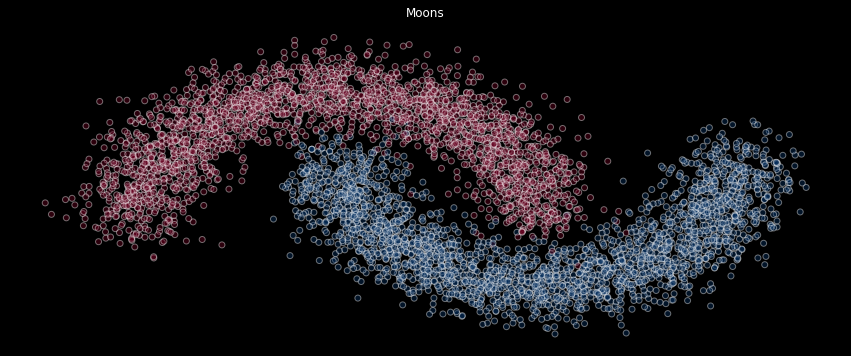

In [7]:
#выведем датасэт на экран
plt.figure(figsize=(15,6))
plt.title('Moons')
plt.scatter(X[:, 0], X[:,1],
           c=y,
           cmap='RdBu',
           alpha=0.42,
           ec='white')
plt.axis('off')
plt.show()

plt.scatter(X[:, 0], X[:,1], #данные точек

           c=y,
           
           cmap='RdBu', #выбор цветов
           
           alpha=0.42, #прозрачность
           
           ec='white') #цвет контура точек

Как видно, с помощью линейной модели мы не сможем корректно реить данную задачу. Часть точек будет классифицирована некорректно.

Данную задачу сначала мы будем решать с помощью линейной модели, а потом напишем свою нейросетевую модель. Т.к. нейросеть может находить нелинейные решения.

И посмотрим, насколько лучше нейронная сеть справляется с такой задачей.

In [8]:
#делим данные на тренировочный и тестовый сет
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [9]:
#получаем тензоры из нампай и приводим его к 32 битам, для экономии памяти
train_X = torch.from_numpy(X_train).to(torch.float32)
train_y = torch.from_numpy(y_train).type_as(train_X)
#аналогично сделаем с валидацией
val_X = torch.from_numpy(X_val).to(torch.float32)
val_y = torch.from_numpy(y_val).type_as(val_X)

In [10]:
train_X.dtype, train_y.dtype

(torch.float32, torch.float32)

In [11]:
type(train_X), type(train_y), type(val_X), type(val_y)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

#### Подготовка данных к обучению

[Что такое pyTorch Dataloader и Dataset](#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) и про [TensorDataset](#https://stackoverflow.com/questions/67683406/difference-between-dataset-and-tensordataset-in-pytorch)

In [12]:
#создаем батч (часть данных, которая будет грузиться за 1 раз)
#делают его, чтобы не перегражать устройство в процессе обучения
BATCH = 64 #батчи задаем через глобальную переменную для удобства изменений
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

#создаем загрузчики
train_loader = DataLoader(train_dataset, batch_size = BATCH)
val_loader = DataLoader(val_dataset, batch_size = BATCH)

In [13]:
#проитерируемся по данным батчей
next(iter(train_loader))

[tensor([[ 1.0004,  0.8002],
         [ 0.8939, -0.6853],
         [ 0.8986,  0.2994],
         [ 0.1065,  0.4086],
         [ 0.4683,  0.9134],
         [ 1.7658, -0.3047],
         [-1.2086,  0.6061],
         [ 0.9629,  0.7460],
         [-0.9185,  0.4370],
         [-0.4932,  1.0971],
         [ 0.0297,  0.8338],
         [-0.9087,  0.4381],
         [-0.9307,  0.1575],
         [ 0.9154, -0.5770],
         [ 0.1783,  0.9633],
         [ 1.8527, -0.5560],
         [ 1.1903,  0.2228],
         [ 2.0332,  0.5498],
         [ 0.1604,  1.3143],
         [ 0.2614, -0.1001],
         [-1.0280,  0.1765],
         [ 0.6630,  0.6603],
         [ 0.5437,  0.6328],
         [ 0.8913, -0.5819],
         [-0.2893,  1.0663],
         [ 0.4571, -0.4091],
         [-0.9142,  0.5102],
         [ 2.0027,  0.1656],
         [ 2.0481,  0.1749],
         [ 1.1574, -0.5607],
         [-0.2566,  1.0266],
         [-0.7999,  0.4205],
         [ 0.0514,  0.1397],
         [ 0.7903,  0.6220],
         [ 0.2

In [14]:
#Создаем Device для очистки кэша
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
DEVICE

'cuda'

#### Линейная модель в pyTorch

$$ y = xW + b $$
, где

y - целевая переменная

x - матрица признаков

W - веса (признаки)

b - коэффициент байеса

In [16]:
class MyLinearRegression(nn.Module):
    #1ый обязательный метод - правило по которому экземпляр класса будет инициализироваться
    def __init__(self, in_features, out_features):
        super().__init__() #обязательно, это надо, чтобы nn.Module узнал, какие параметры мы передали
        self.W = nn.Parameter(torch.randn((in_features, out_features), 
                                          requires_grad=True)) #наш слой
        self.b = nn.Parameter(torch.ones(out_features), 
                                          requires_grad=True) #байес
        
    #2ой обязательный метод
    #прямое прохождение данных через нашу модель
    def forward(self, x):
        x = x @ self.W
        x += self.b
        return x

#### Обучение

In [18]:
# подготовка
# 1. Задать модель - nn.Module
model = MyLinearRegression(2, 1)
# 2. Задать функцию потерь - nn.NAME_OF_FUNC
loss_function = nn.BCEWithLogitsLoss()
# 3. Задать оптимизатор - torch.optim.NAME_OF_OPTIM
optimizer = torch.optim.SGD(model.parameters(), lr=0.042)

# поместить модель и метрику на GPU
model = model.to(DEVICE)
accuracy = BinaryAccuracy().to(DEVICE)
# создать вспомогательные списки для данных
# н-р, лосс на каждой итераций
losses_train = []
# н-р, общий лосс
total_loss = []
# н-р, accuracy
acc_val = []
# задать общее количество эпох
MAX_EPOCHS = 100
# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
    # для каждой части датасета
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        # ЭТАП ОБУЧЕНИЯ
        # переводим модель в режим обучения
        model.train()
        # ОБНУЛЯЕМ градиенты у оптимизатора
        optimizer.zero_grad()
        # пропускам данные через модель
        outputs = model(X_batch.to(DEVICE))
        # выравняем выходы в одномерный тензор
        outputs = outputs.view(-1)
        # считаем лосс
        loss = loss_function(outputs, y_batch.to(DEVICE))
        # делаем шаг в обратном направлении
        loss.backward()
        # собираем лоссы
        losses_train.append(loss.detach().cpu().numpy().item())
        # делаем шаг оптимизатора
        optimizer.step()
    # собираем средний лосс
    total_loss.append(np.mean(losses_train))
    # ШАГ ВАЛИДАЦИИ
    for iteration, (X_batch, y_batch) in enumerate(val_loader):
        # режим инференса или валидации, тестирования
        model.eval()
        # обязательно добавить
        with torch.no_grad():
            outputs = model(X_batch.to(DEVICE))
            outputs = outputs.view(-1)
            loss = loss_function(outputs, y_batch.to(DEVICE))
            # считаем вероятности
            proba = torch.sigmoid(outputs)
            # считаем метрику
            batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
            acc_val.append(batch_acc.detach().cpu().numpy().item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
acc = np.mean(acc_val)
print(f"Accuracy линейной модели {acc:.2%}")

Accuracy линейной модели 87.13%


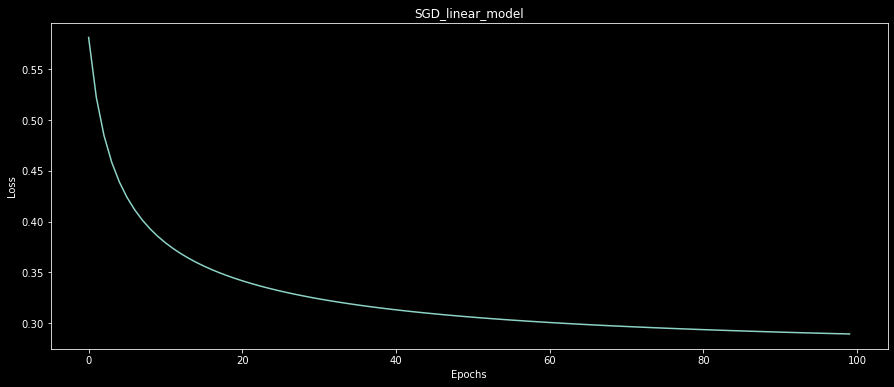

In [20]:
plt.figure(figsize=(15,6))
plt.plot(range(len(total_loss)),
        total_loss,
        linestyle='-')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("SGD_linear_model")
plt.show()

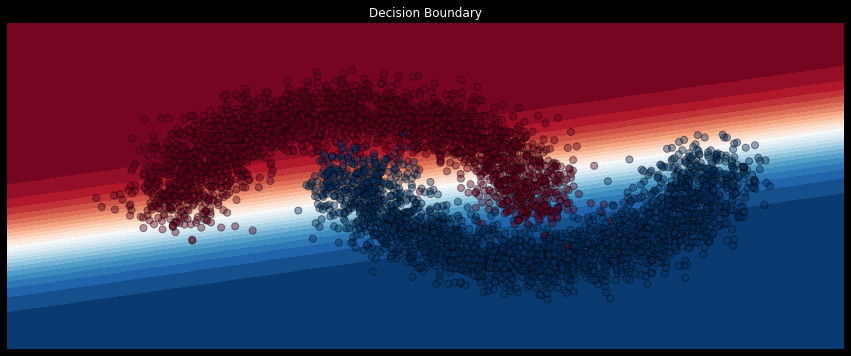

In [23]:
plot_decision_boundary(model.to("cpu"))

In [24]:
#очистим кэш
with torch.no_grad():
  torch.cuda.empty_cache()

### Полносвязная сеть в pyTorch

In [26]:
#Как не стоит работать с pyTorch
activation = nn.ReLU()
model = nn.Sequential(nn.Linear(2, 4),
                      nn.Dropout(p=0.5),
                      activation,
                      nn.Linear(4,1)
)

In [27]:
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=1, bias=True)
)

In [39]:
# как мы будем учиться работать с pyTorch
class NNsuper(nn.Module):
  # 1ый обязательный метод
  def __init__(self, in_features, out_features):
    super().__init__() # обязательно
    #   self.linear = nn.Sequential(
    #                     nn.Linear(2, 4),
    #                     nn.Dropout(p=.5),
    #                     activation,
    #                     nn.Linear(4, 1)
    # )
    self.lin_linear_1 = self.make_layer(in_features, in_features * 4)
    self.lin_linear_2 = self.make_layer(in_features * 4, in_features * 2)
    self.lin_linear_3 = self.make_layer(in_features * 2, out_features)
    self.relu = F.relu
  
  def make_layer(self, in_f, out_f):
    return nn.Linear(in_f, out_f)

  # 2ой обязательный метод
  def forward(self, x):
    x = self.lin_linear_1(x)
    x = self.relu(x)
    
    x = self.lin_linear_2(x)
    x = self.relu(x)
    x = self.lin_linear_3(x)
    return x

### Обучение

In [40]:
# подготовка
# 1. Задать модель - nn.Module
model = NNsuper(2, 1)
# 2. Задать функцию потерь - nn.NAME_OF_FUNC
loss_function = nn.BCEWithLogitsLoss()
# 3. Задать оптимизатор - torch.optim.NAME_OF_OPTIM
optimizer = torch.optim.Adam(model.parameters(), lr=0.042)

In [41]:
#параметры, по которым будет считать наша нейросеть
list(model.parameters())

[Parameter containing:
 tensor([[ 0.6171, -0.3974],
         [-0.2529,  0.2328],
         [-0.4756, -0.4138],
         [-0.3790, -0.6256],
         [-0.2864, -0.1978],
         [-0.7031,  0.4429],
         [-0.2725,  0.3327],
         [-0.4904,  0.5544]], requires_grad=True),
 Parameter containing:
 tensor([-0.4545, -0.2140,  0.1347,  0.5138,  0.6063,  0.5695, -0.1806, -0.0066],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0355,  0.1371, -0.0492,  0.3158, -0.2026,  0.2100,  0.0162, -0.1149],
         [ 0.0626,  0.3179, -0.3186,  0.2556, -0.1917, -0.1652, -0.0291,  0.3524],
         [-0.1696,  0.1804,  0.2541,  0.0315, -0.2602, -0.0410,  0.1028,  0.0835],
         [-0.2827,  0.1341,  0.1473,  0.0903, -0.2307, -0.3410, -0.0591,  0.0307]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0617, -0.1274, -0.2504, -0.3126], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3125, -0.0503, -0.4136, -0.3507]], requires_grad=True),
 Parameter containing:

In [42]:
# поместить модель и метрику на GPU
model = model.to(DEVICE)
accuracy = Accuracy().to(DEVICE)
# создать вспомогательные списки для данных
# н-р, лосс на каждой итераций
losses_train = []
# н-р, общий лосс
total_loss = []
# н-р, accuracy
acc_val = []
# задать общее количество эпох
MAX_EPOCHS = 100
# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
  # для каждой части датасета
  for iteration, (X_batch, y_batch) in enumerate(train_loader):
    # ЭТАП ОБУЧЕНИЯ
    # мы переводим модель в режим обучения
    model.train()
    # ОБНУЛЯЕМ градиенты у оптимизатора
    optimizer.zero_grad()
    # пропускам данные через модель
    outputs = model(X_batch.to(DEVICE))
    # выравняем выходы в одномерный тензор
    outputs = outputs.view(-1)
    # считаем лосс
    loss = loss_function(outputs, y_batch.to(DEVICE))
    # делаем шаг в обратном направлении
    loss.backward()
    # собираем лоссы
    losses_train.append(loss.detach().cpu().numpy().item())
    # делаем шаг оптимизатора
    optimizer.step()
  # собираем средний лосс
  total_loss.append(np.mean(losses_train))
  # ШАГ ВАЛИДАЦИИ
  for iteration, (X_batch, y_batch) in enumerate(val_loader):  
    # режим инференса или валидации, тестирования
    model.eval()
    # обязательно добавить
    with torch.no_grad():
      outputs = model(X_batch.to(DEVICE))
      outputs = outputs.view(-1)
      loss = loss_function(outputs, y_batch.to(DEVICE))
      # считаем вероятности
      proba = torch.sigmoid(outputs)
      # ситаем метрику
      batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
      acc_val.append(batch_acc.detach().cpu().numpy().item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
acc = np.mean(acc_val)
print(f"Accuracy полносвязной нейронной сети {acc:.2%}")

Accuracy полносвязной нейронной сети 98.69%


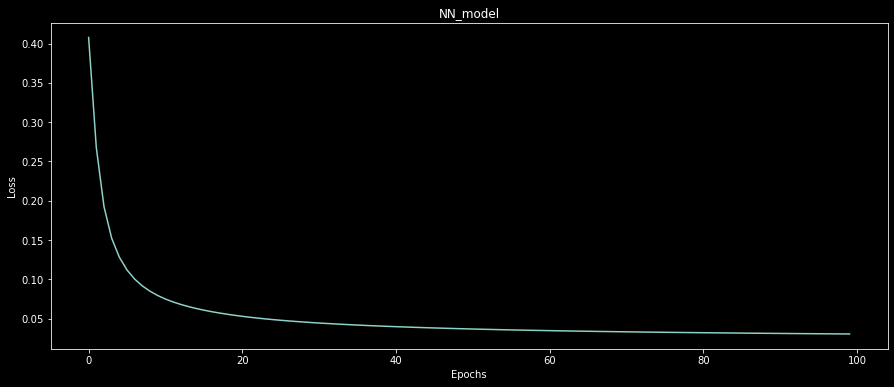

In [47]:
plt.figure(figsize=(15,6))
plt.plot(range(len(total_loss)),
        total_loss,
        linestyle='-')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("NN_model")
plt.show()

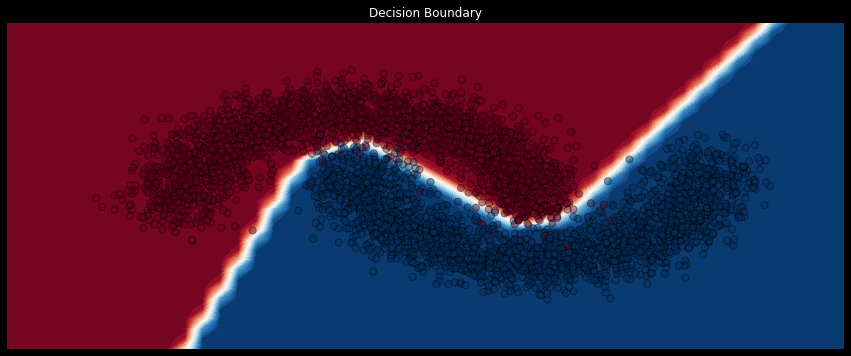

In [45]:
plot_decision_boundary(model.to("cpu"))

In [ ]:
#очистим кэш
with torch.no_grad():
  torch.cuda.empty_cache()

Полезные ссылки:   


- [Deep learning School](https://mipt.ru/science/labs/innovation/projects/deep_learning_school) - Школа глубокого обучения (Deep Learning School) — ФПМИ МФТИ;  
- [pyTorch tutorial](https://pytorch.org/tutorials/) - Официальный туториал `pyTorch`;  
- [Kaggle competition - Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer) - соревнование `Kaggle` по распознаванию цифр и [pyTorch Mnist tutorial](https://pythonguides.com/pytorch-mnist/);   
- [Kaggel competition - Titanic](https://www.kaggle.com/c/titanic) - соревнование по классификации - подсказка - количество признаков == количеству входов в первом слое;  
- [pyTorch metrics](https://torchmetrics.readthedocs.io/en/stable/) - вспомогательная библиотека для подсчета метрик;  
- [pyTorch Lightning](https://www.pytorchlightning.ai/tutorials) - вспомогательная библиотка, которая помогает писать меньше кода для `pyTorch`
- [ООП](https://proproprogs.ru/python_oop) - немного про ООП доступно
